<a href="https://colab.research.google.com/github/Neo-glitch/computer-vision-masterclass/blob/main/GANS_Fashion_Mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [124]:
import tensorflow as tf
import tensorflow.keras as keras
import numpy as np
import matplotlib.pyplot as plt
import numpy as np

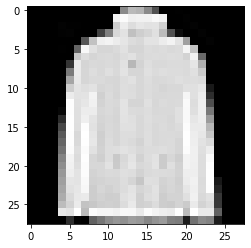

In [125]:
(x_train, y_train), (_, _) = keras.datasets.fashion_mnist.load_data()

i = np.random.randint(0, 60000)

plt.imshow(x_train[i], cmap = "gray")

In [126]:
# add extra dim to dim of images
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1).astype('float32')

In [127]:
x_train = (x_train - 127.5) / 127.5
x_train.min(), x_train.max()

(-1.0, 1.0)

In [128]:
buffer_size = 30000
batch_size = 32

x_train = tf.data.Dataset.from_tensor_slices(x_train).shuffle(buffer_size).batch(batch_size)

In [129]:
def build_generator():

  nn = keras.Sequential()
  
   # the neuron amount was taken from a gan tutorial, could play with this though
  # for more complex images, we need more neurons and more layers
  nn.add(tf.keras.layers.Dense(units = 7*7*256, use_bias = False, input_shape = (128,)))
  nn.add(tf.keras.layers.BatchNormalization())
  nn.add(tf.keras.layers.LeakyReLU())

  # since we are using a conv layer after this, we need to have it in tensor format, else just exclude this layer
  nn.add(tf.keras.layers.Reshape((7, 7, 256)))  
  
  # giving 7 x 7 x 128
  nn.add(tf.keras.layers.Conv2DTranspose(128, (5, 5), padding = "same", use_bias = False)) 
  nn.add(tf.keras.layers.BatchNormalization())
  nn.add(tf.keras.layers.LeakyReLU())

  # giving 14 x 14 x 64
  nn.add(tf.keras.layers.Conv2DTranspose(64, (5, 5), padding = "same", strides = (2,2), use_bias = False))
  nn.add(tf.keras.layers.BatchNormalization())
  nn.add(tf.keras.layers.LeakyReLU())


  # giving 28 x 28 x 1 (our image shape)
  # tanh activation is used to get pixel values in range -1 and 1 as we did in normalization
  # use sigmoid i.e 0 -1 when normalization used makes pixel to be in range 0 - 1
  nn.add(tf.keras.layers.Conv2DTranspose(1, (5, 5), padding = "same", strides = (2,2), use_bias = False, activation = "tanh"))

  nn.summary()

  return nn

In [130]:
generator = build_generator()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_14 (Dense)            (None, 12544)             1605632   
                                                                 
 batch_normalization_21 (Bat  (None, 12544)            50176     
 chNormalization)                                                
                                                                 
 leaky_re_lu_35 (LeakyReLU)  (None, 12544)             0         
                                                                 
 reshape_7 (Reshape)         (None, 7, 7, 256)         0         
                                                                 
 conv2d_transpose_21 (Conv2D  (None, 7, 7, 128)        819200    
 Transpose)                                                      
                                                                 
 batch_normalization_22 (Bat  (None, 7, 7, 128)      

In [131]:
def build_discriminator():
  network = tf.keras.Sequential()

  # output of block = 14 x 14 x 64 (using conv dim reduction formular to get this)
  network.add(tf.keras.layers.Conv2D(64, (5, 5), strides = (2,2), padding = "same", input_shape = [28, 28, 1]))
  network.add(tf.keras.layers.LeakyReLU())
  network.add(tf.keras.layers.Dropout(0.3))

  # 7 x 7 x 128
  network.add(tf.keras.layers.Conv2D(128, (5, 5), strides = (2,2), padding = "same"))
  network.add(tf.keras.layers.LeakyReLU())
  network.add(tf.keras.layers.Dropout(0.3))

  network.add(tf.keras.layers.Flatten())
  network.add(tf.keras.layers.Dense(1))

  network.summary()

  return network

In [132]:
discriminator = build_discriminator()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_14 (Conv2D)          (None, 14, 14, 64)        1664      
                                                                 
 leaky_re_lu_38 (LeakyReLU)  (None, 14, 14, 64)        0         
                                                                 
 dropout_14 (Dropout)        (None, 14, 14, 64)        0         
                                                                 
 conv2d_15 (Conv2D)          (None, 7, 7, 128)         204928    
                                                                 
 leaky_re_lu_39 (LeakyReLU)  (None, 7, 7, 128)         0         
                                                                 
 dropout_15 (Dropout)        (None, 7, 7, 128)         0         
                                                                 
 flatten_7 (Flatten)         (None, 6272)            

**Loss calculation**

In [133]:
cross_entropy = keras.losses.BinaryCrossentropy(from_logits = True)

def discriminator_loss(expected_logits, fake_logits):
  real_loss = cross_entropy(tf.ones_like(expected_logits), expected_logits)
  fake_loss = cross_entropy(tf.zeros_like(fake_logits), fake_logits)

  total_loss = (real_loss + fake_loss)
  return total_loss

def generator_loss(fake_logits):
  return cross_entropy(tf.ones_like(fake_logits), fake_logits)

In [134]:
gen_optimizer = keras.optimizers.Adam(learning_rate = 0.00001)
disc_optimizer = keras.optimizers.Adam(learning_rate = 0.00001)

**Model Training**

In [135]:
epochs = 150
noise_dim = 128
num_image_to_gen = 10

In [136]:
@tf.function
def train_steps(images):
  noise = tf.random.normal([batch_size, noise_dim])

  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    gen_images = generator(noise, training = True)

    expected_logits = discriminator(images, training = True)
    fake_logits = discriminator(gen_images, training = True)

    gen_loss = generator_loss(fake_logits)
    disc_loss = discriminator_loss(expected_logits, fake_logits)

  grad_of_gen = gen_tape.gradient(gen_loss, generator.trainable_variables)
  grad_of_disc = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

  gen_optimizer.apply_gradients(zip(grad_of_gen, generator.trainable_variables))
  disc_optimizer.apply_gradients(zip(grad_of_disc, discriminator.trainable_variables))




In [137]:
# images to be passed for generation after each epoch of training
# after every 50 epochs
test_images = tf.random.normal([num_image_to_gen, noise_dim])

test_images.shape

TensorShape([10, 128])

In [138]:
def train(dataset, epochs, test_images):
  for epoch in range(epochs):
    for batch in dataset:
      train_steps(batch)

    if (epoch % 10 == 0):
      print("Epochs: ", epoch + 1)
      generated_images = generator(test_images, training = False)
      fig = plt.figure(figsize = (8, 8))
      for i in range(generated_images.shape[0]):
        plt.subplot(4, 4, i+1)
        # multiply by 127.5 and add 127.5 to do reverse of normalization
        plt.imshow(generated_images[i, :, :, 0] * 127.5 + 127.5, cmap = "gray")
        plt.axis("off")
      plt.show()


Epochs:  1


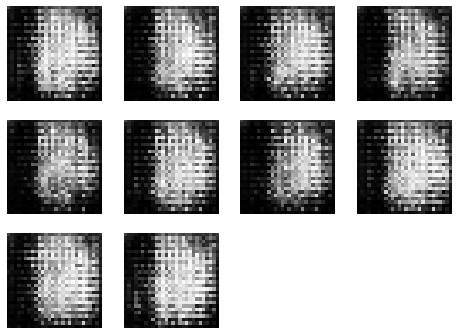

Epochs:  11


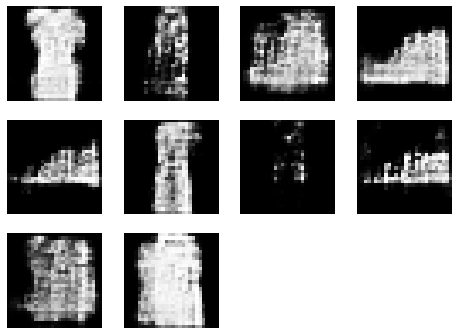

Epochs:  21


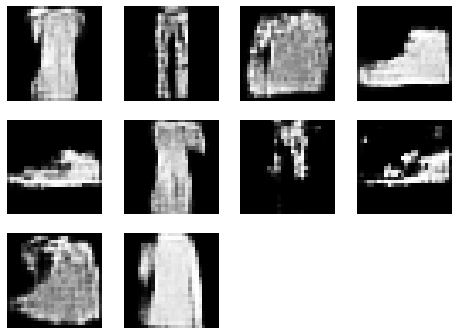

Epochs:  31


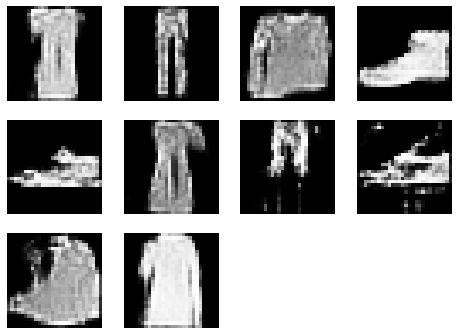

Epochs:  41


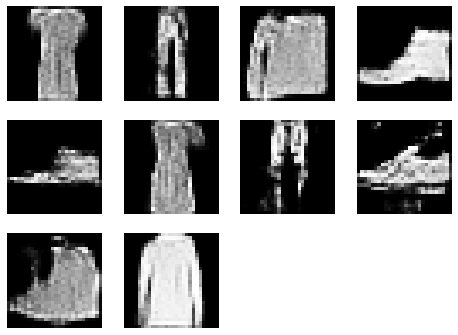

Epochs:  51


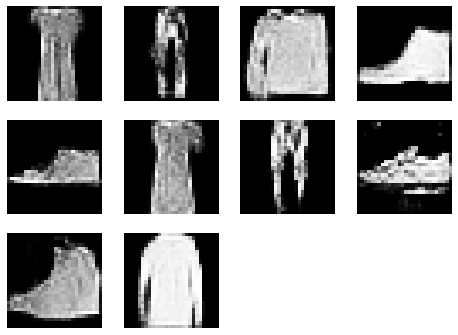

Epochs:  61


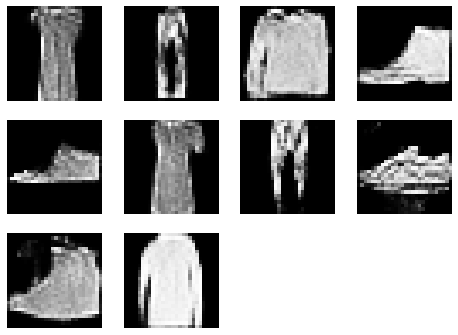

Epochs:  71


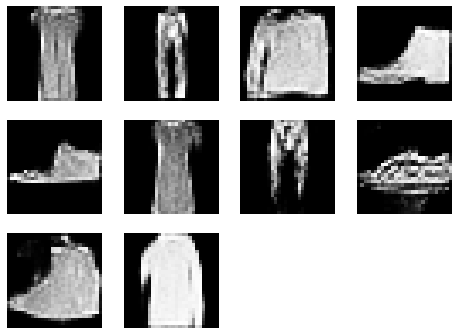

Epochs:  81


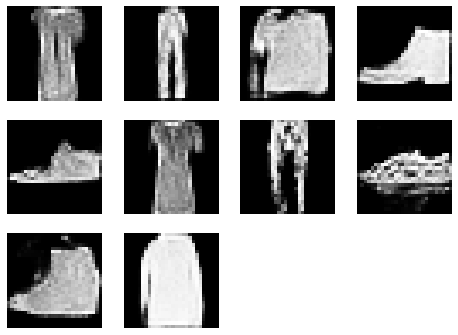

Epochs:  91


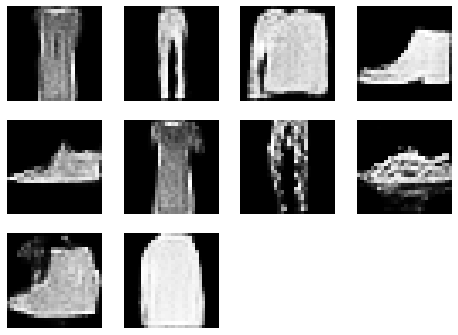

Epochs:  101


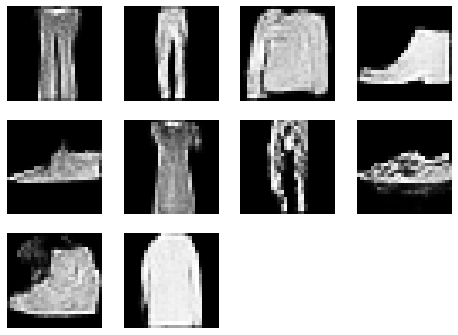

Epochs:  111


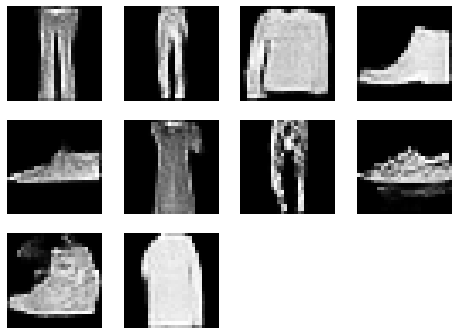

Epochs:  121


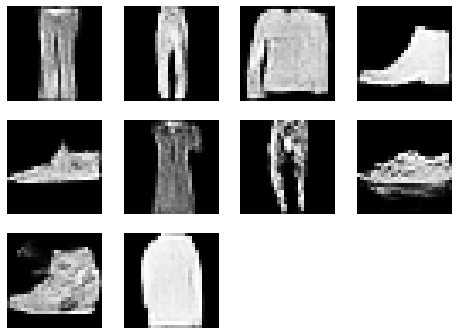

Epochs:  131


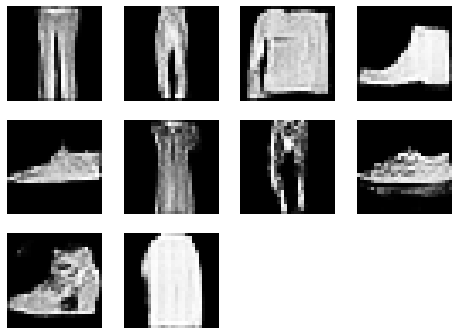

Epochs:  141


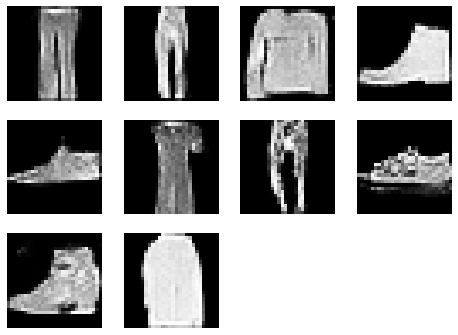

In [139]:
 # begin training
train(x_train, epochs, test_images)

**Image Generation**

In [164]:
random_img = tf.random.normal([20, noise_dim])

generated_test_images = generator(random_img, training=False)

In [166]:
generated_test_images.shape

TensorShape([20, 28, 28, 1])

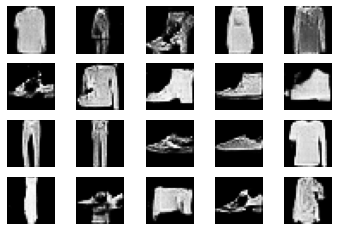

In [168]:
for i in range(generated_test_images.shape[0]):
  plt.subplot(4, 5, i+1)
  # multiply by 127.5 and add 127.5 to do reverse of normalization
  plt.imshow(generated_test_images[i, :, :, 0] * 127.5 + 127.5, cmap = "gray")
  plt.axis("off")
plt.show()
